In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Data

In [2]:
train_df = pd.read_json('train.json',  lines = True).drop(['index'], axis = 1)
test_df = pd.read_json('test.json', lines = True).drop(['index'], axis = 1)

In [4]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSXZ')}

target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )

train_inputs = preprocess_inputs(train_df.loc[train_df.SN_filter == 1])
train_labels = np.array(train_df.loc[train_df.SN_filter == 1][target_cols].values.tolist()).transpose((0, 2, 1))

In [6]:
from sklearn.model_selection import train_test_split

seed = 123
X_train, X_test, Y_train, Y_test = train_test_split(train_inputs, train_labels, test_size = 0.1, random_state = seed)

print(np.shape(X_train)) #1430 samples de séquences de 107 de long et de 3=sequence,structure, predicted loop type

(1430, 107, 3)


# Model

In [19]:
import tensorflow.keras.layers as L
def gru_layer(hidden_dim, dropout):
    return L.Bidirectional(L.GRU(hidden_dim, dropout=dropout, return_sequences=True))

def build_model(seq_len=107, pred_len=68, dropout=0.5, embed_dim=75, hidden_dim=128):
    inputs = L.Input(shape=(seq_len, 14))

    embed = L.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))

    hidden = gru_layer(hidden_dim, dropout)(reshaped)
    hidden = gru_layer(hidden_dim, dropout)(hidden)
    hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    # Since we are only making predictions on the first part of each sequence, we have
    # to truncate it
    truncated = hidden[:, :pred_len]
    
    out = L.Dense(3, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    model.compile(tf.keras.optimizers.Adam(), loss='mse',  metrics=['accuracy'])
    
    return model

In [30]:
def build_model(seq_len=107, pred_len=68, dropout=0.5, embed_dim=75, hidden_dim=128):
    inputs = L.Input(shape=(seq_len, 3))

    embed = L.Embedding(input_dim=len(token2int), output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))

    hidden = gru_layer(hidden_dim, dropout)(reshaped)
    hidden = gru_layer(hidden_dim, dropout)(hidden)
    hidden = gru_layer(hidden_dim, dropout)(hidden)
    
    # Since we are only making predictions on the first part of each sequence, we have
    # to truncate it
    truncated = hidden[:, :pred_len]
    
    out = L.Dense(5, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    model.compile(tf.keras.optimizers.Adam(), loss='mse',  metrics=['accuracy'])
    
    return model

In [31]:
def prepare_window_training(base_index, n_bases,X_train, Y_train, X_test, Y_test):
   
    start_index=int(i-(window_size-1)/2)
    stop_index=int(i+(window_size-1)/2 +1) #not included
    full_array=[]
    for sample_index in range(len(X_train)):
        sample_array=X_train[sample_index]

        if start_index<0:
            out_array=np.array([[14]*len(sample_array[0])]*(-int(start_index)))
            studied_cut_array=sample_array[0:stop_index]
            studied_array=np.concatenate((out_array,studied_cut_array))

        elif stop_index>68:
            out_array=np.array([[14]*len(sample_array[0])]*(int(stop_index-68)))
            studied_cut_array=sample_array[start_index:68]
            studied_array=np.concatenate((studied_cut_array,out_array))

        else :
            studied_array=sample_array[start_index:stop_index]
        full_array.append(studied_array)
    
    full_array_test=[]
    for sample_index in range(len(X_test)):
        sample_array=X_test[sample_index]

        if start_index<0:
            out_array=np.array([[14]*len(sample_array[0])]*(-int(start_index)))
            studied_cut_array=sample_array[0:stop_index]
            studied_array=np.concatenate((out_array,studied_cut_array))

        elif stop_index>68:
            out_array=np.array([[14]*len(sample_array[0])]*(int(stop_index-68)))
            studied_cut_array=sample_array[start_index:68]
            studied_array=np.concatenate((studied_cut_array,out_array))

        else :
            studied_array=sample_array[start_index:stop_index]
        full_array_test.append(studied_array)

    X_train_window=np.array(full_array)
    Y_train_window=Y_train[:,i,:]
    X_test_window=np.array(full_array_test)
    Y_test_window=Y_test[:,i,:]
    
    return X_train_window, Y_train_window, X_test_window, Y_test_window

# Window mode


Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 21, 3)]           0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 21, 3, 15)         225       
_________________________________________________________________
tf_op_layer_Reshape_10 (Tens [(None, 21, 45)]          0         
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 21, 256)           134400    
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 21, 256)           296448    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 21, 256)           296448    
_________________________________________________________________
tf_op_layer_strided_slice_9  [(None, 21, 256)]       

InvalidArgumentError:  Input to reshape is a tensor with 45 values, but the requested shape requires a multiple of 945
	 [[node functional_19/tf_op_layer_Reshape_10/Reshape_10 (defined at <ipython-input-33-2904ca280399>:47) ]] [Op:__inference_predict_function_75380]

Function call stack:
predict_function


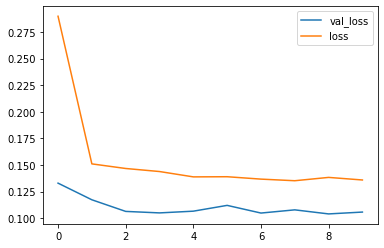

In [33]:
#mode fenêtré:
window_size=21 #doit être un nombre impair
X_train=X_train[:,:68,:]
X_test=X_test[:,:68,:]

X_to_predict = preprocess_inputs(train_df)[:,:68,:]


for i in range(68): #on parcourt toute la séquence

    X_train_window, Y_train_window, X_test_window, Y_test_window = prepare_window_training(i, 68, 
                                                                                   X_train, Y_train, 
                                                                                   X_test, Y_test)
    #ici il faut faire le fit sur le full_array de dimensions 2160*21*14=nombredeséquences*window_size*nombredeparamètresd'input
    #ensuite on lance le modèle sur les vraies données, 
    #et on stocke le résultat [a,b,c] dans l'item i une liste du type [[1, 0, 0], [0, 1, 0.3], [0.4, 0.7, 1], ...], de dimensions 68*3
    
    model = build_model(seq_len=21, embed_dim=len(token2int))
    model.summary()
    Y_train_window=np.array([np.tile(Y_train_window[i],(21,1)) for i in range(len(Y_train_window))])
    Y_test_window=np.array([np.tile(Y_test_window[i],(21,1)) for i in range(len(Y_test_window))])

    print(np.shape(X_train_window))
    print(np.shape(Y_train_window))
    print(np.shape(X_test_window))
    print(np.shape(Y_test_window))
    
    history = model.fit(
    X_train_window, 
    Y_train_window,
    validation_data=(X_test_window, Y_test_window),
    batch_size=32,
    epochs=10,
    verbose=2,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=5),
        tf.keras.callbacks.ModelCheckpoint('model.h5')
    ]
    )
    plt.subplot()
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.legend(['val_loss', 'loss'], loc='upper right')
    
# la prédiction qui suit ne marche pas encore 

#     for seq in range(len(X_to_predict)) :
#         base_predict=model.predict(X_test_window[0,:,:])
#         Y_predicted[seq, i, :]=np.mean(base_predict, axis=0)

#         print(Y_predicted[seq,i,:])
    

Dans la préparation des données, (mode fenêtré), au lieu de mettre des -1 (ou des 14 en fait) à la fin de la séquence on peut mettre les vraies bases et structures